In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/restaurant recomendation system/

/content/gdrive/MyDrive/restaurant recomendation system


In [ ]:

!pip install plotly_express

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

## Importing Basic Packages

import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 50)

# Importing Plotly Packages

import plotly 
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px

# Importing sklearn Packages

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

# Importing scipy Packages
from scipy.sparse.linalg import svds

In [ ]:

# Reading in Combined Reviews CSV File

final_reviews = pd.read_csv("/content/gdrive/MyDrive/restaurant recomendation system/final_reviews.csv")
final_reviews.drop(['Unnamed: 0'], axis=1, inplace = True)
print(final_reviews.shape)
final_reviews.head(3)

(78260, 25)


,business_id,review_id,user_id,stars,useful,funny,cool,text,date,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,compound_score,sentiment,Dominant_Topic,Keywords,Text_Chunks
0,cPDX2Y4H0fks-Qj5tfBduA,YP4dpdLt7iomIJGIweKTjg,K97i0e7MaxYfvCCwPFMjuw,3.0,0.0,0.0,0.0,This is solely for the cupcakes. So I retuned ...,2011-07-24 17:44:29,109.0,582.0,4.348624,44.0,solely cupcakes retuned tartes sweet treats co...,-0.060185,0.304630,0.074,0.844,0.082,-0.0066,-0.0066,neutral,2.0,"pizza, cake, wing, chocolate, ice, pie, cream,...","['solely', 'cupcake', 'retune', 'tarte', 'swee..."
1,cPDX2Y4H0fks-Qj5tfBduA,Dsz8hsLQNDJntT45PxG4HQ,ubPlKiHayyv2puouC1faMQ,5.0,0.0,0.0,0.0,An enchantingly wonderful happy place! Tartes...,2016-03-04 23:56:35,48.0,264.0,4.617021,17.0,enchantingly wonderful happy place tartes favo...,0.500000,0.800000,0.000,0.662,0.338,0.9682,0.9682,positive,4.0,"place, food, great, service, price, really, we...","['enchantingly', 'wonderful', 'happy', 'place'..."
2,cPDX2Y4H0fks-Qj5tfBduA,d6HqIoLPBkBGE_eME6P3aA,0ENLV8uFNuZEehc48HwYzw,5.0,1.0,0.0,1.0,"Perfect coconut, key lime and apple crumb tart...",2012-04-14 19:32:15,54.0,302.0,4.611111,18.0,perfect coconut key lime apple crumb tarts alw...,0.334375,0.634615,0.016,0.727,0.257,0.9507,0.9507,positive,4.0,"place, food, great, service, price, really, we...","['perfect', 'coconut', 'key', 'lime', 'apple',..."


Creating a Super-Score Rating
The first step to building our recommendation systems is to develop a rating score that reflects each user's overall preference for a restaurant. In our reviews dataset, we have the actual rating(stars) that users have indicated in their Yelp Reviews. However, we will try and build our own Super Score rating by combining these ratings with other sentiment scores like Textblob's polarity and VADER compound scores.

The polarity of a text ranges from -1 to +1, negative to positive.
The subjectivity score ranges from 0 to 1, very objective to very subjective.
The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive).
Formula: Super Score = stars + (polarity x compound)

In [ ]:

# Computing Super-Score Rating for Reviews

final_reviews['super_score'] = final_reviews['polarity'] *  final_reviews['compound']
final_reviews['super_score'] = final_reviews['super_score'] + final_reviews['stars']
final_reviews.sample(3)

,business_id,review_id,user_id,stars,useful,funny,cool,text,date,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,compound_score,sentiment,Dominant_Topic,Keywords,Text_Chunks,super_score
23977,NYj8uB9-u0SmRMNDNktb1g,FdQxOztu1Nfbgr4m8mDQBQ,H1IZrCGg4XR4oHbGCdQQGg,4.0,1.0,2.0,1.0,It is what it is. And that's a great little d...,2007-04-17 01:20:27,58.0,287.0,4.259259,21.0,thats great little dive draws mixed crowd one ...,0.151389,0.411111,0.000,0.864,0.136,0.8481,0.8481,positive,0.0,"table, drink, night, dinner, beer, restaurant,...","['probably', 'favorite', 'steakhouse', 'town',...",4.128393
13594,N2kFhCeHWw5B9nxjtkgotQ,xP_rl265mrCAz0ecVVOm3A,I4dngjy_JIF8EVQRsfVMJA,1.0,1.0,0.0,0.0,Service was slow! Waitress seem to be high off...,2019-04-05 00:49:14,93.0,472.0,4.086022,45.0,service slow waitress high something crabs col...,-0.353519,0.533148,0.122,0.828,0.050,-0.8564,-0.8564,negative,1.0,"salad, dish, sauce, order, bread, taste, meat,...","['pleasure', 'dine', 'bistrot', 'minette', 'ti...",1.302753
32865,8KBDQlSdjJ-NoLbpPvkOrw,5b28KmQ6WnveN6mfF8dA2A,5bJpDx4c7x9fYzdltOhfbw,4.0,1.0,0.0,0.0,I had a wonderful dinner here on a few months ...,2015-11-13 02:50:44,84.0,432.0,4.130952,30.0,wonderful dinner months ago realized never wro...,0.416667,0.495833,0.028,0.629,0.343,0.9912,0.9912,positive,0.0,"table, drink, night, dinner, beer, restaurant,...","['wedding', 'last', 'weekend', 'amazing', 'tim...",4.413000


In [ ]:

# Minimum Super Score Rating

final_reviews['super_score'].min()

0.2319

In [ ]:
# Maximum Super Score Rating

final_reviews['super_score'].max()


5.9719999999999995

The range of Super Score Ratings is from [0,6].

Recommender systems have a problem known as user cold-start, in which it is hard to provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.

For example, if I am new to a city or I am a new user of a food delivery app, it will be difficult to provide personal recommendations due to the lack of information about my own personal preferences with regards to food and restaurants.

With the cold-start problem, we have to give good recommendations to users that have provided no feedback. Essentially, their data is empty, and there are no relations that can be inferred for this user. The naive solution for this problem could be to first give a random recommendation, and for every following recommendation: take feedback, retrain, sort the predicted ratings, and return the highest projected recommendation.

One way where we can give a new user recommendations would be through location proximity data. Knowing a person's geographical location at the point of time where he is deciding to find new Restaurants to visit, we can use a Location-Based Recommendation System to recommend Restaurants near his/her vicinity. By providing an initial recommendation that is convenient for the user, we can attract him to start using our app and thereafter build on his initial preference to recommend other restaurants using our other alternative Recommendation Systems.

Location-Based Recommendation System

In [ ]:


# Reading in Restaurant Businesses Final CSV File

business_final = pd.read_csv("/content/gdrive/MyDrive/restaurant recomendation system/business_final.csv")

print(business_final.shape)
business_final.head(3)

(3527, 11)


,index,business_id,name,city,state,stars,review_count,categories,latitude,longitude,postal_code
0,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",39.955505,-75.155564,19107
1,15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,Philadelphia,PA,4.0,245,"Sushi Bars, Restaurants, Japanese",39.953949,-75.143226,19106
2,19,ROeacJQwBeh05Rqg7F6TCg,BAP,Philadelphia,PA,4.5,205,"Korean, Restaurants",39.943223,-75.162568,19147


In [ ]:

# Filtering for Selected Columns

business_final['business_id'] = business_final['business_id']
business_final = business_final[['business_id', 'name', 'categories','stars','review_count','latitude','longitude','postal_code']]
business_final.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",4.0,80,39.955505,-75.155564,19107
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,"Sushi Bars, Restaurants, Japanese",4.0,245,39.953949,-75.143226,19106
2,ROeacJQwBeh05Rqg7F6TCg,BAP,"Korean, Restaurants",4.5,205,39.943223,-75.162568,19147
3,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,"Eatertainment, Arts & Entertainment, Brewpubs,...",3.5,65,39.962582,-75.135657,19123
4,ppFCk9aQkM338Rgwpl2F5A,Wawa,"Restaurants, Automotive, Delis, Gas Stations, ...",3.0,56,39.954573,-75.194894,19104


In [ ]:
# Geographical Overview of Restaurants in ph City

px.set_mapbox_access_token("pk.eyJ1IjoiY3QzMDU3IiwiYSI6ImNsZmFpN2diMDA1dGQzdG1lNXh4bzYwdmEifQ.Fu4HqAVGPG9XaGVDwEd2pg")
fig = px.scatter_mapbox(business_final, lat="latitude", lon="longitude", color="stars", size='review_count',
                   size_max=15, zoom=10, width=1000, height=700)

fig.update_layout(mapbox_style="dark")
fig.show()

K-Means Clustering
Based on the above visualization, we can see that there are areas in philadelphia where there is a high density of Restaurants while there are also other areas that have fewer Restaurants. Depending on where a user is currently located, it would make sense to recommend restaurants that are close to his location regardless of where he is in a city.

Hence, one way where we can group restaurants together based on geographical location is using the K-Means Clustering Algorithm. The K-Means algorithm predicts the cluster where the user is located in and pulls out this cluster’s top 10 restaurants and recommends them to him.

In [ ]:

# Putting the Coordinates of Restaurants together into a dataframe
coordinates = business_final[['longitude','latitude']]
coordinates # Total of 3527 Locations for 5,471 Unique Restaurants

,longitude,latitude
0,-75.155564,39.955505
1,-75.143226,39.953949
2,-75.162568,39.943223
3,-75.135657,39.962582
4,-75.194894,39.954573
...,...,...
3522,-75.174728,39.925205
3523,-75.157752,39.970720
3524,-75.189916,39.957447
3525,-75.214430,40.032483


In [ ]:
# Elbow method to determine the number of K in Kmeans Clustering

distortions = []
K = range(1,15)
for k in K:
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coordinates)
    distortions.append(kmeansModel.inertia_)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

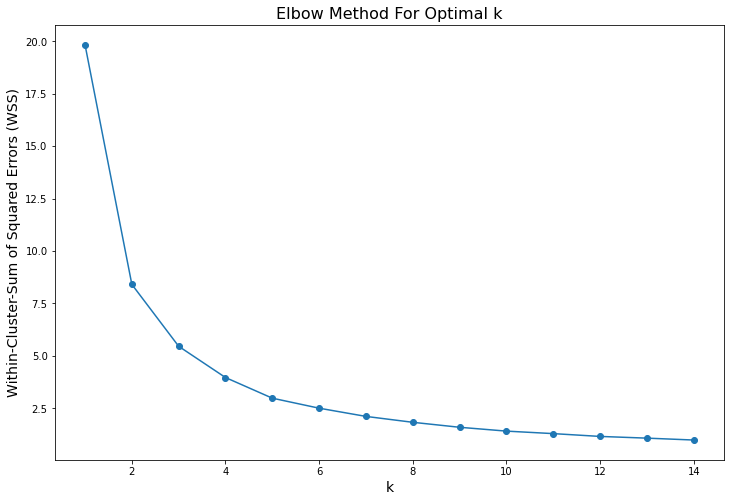

In [ ]:
# Elbow Graph for WSS

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K, distortions, marker='o')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)', fontsize = 14)
plt.title('Elbow Method For Optimal k', fontsize = 16)
plt.show()
     

In [ ]:

# Silhouette Score Method to to determine the number of K in Kmeans Clustering

sil = []
kmax = 25

# Dissimilarity would not be defined for a single cluster. Minimum number of clusters should be 2

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(coordinates)
  labels = kmeans.labels_
  sil.append(silhouette_score(coordinates, labels, metric = 'euclidean'))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change fro

In [ ]:

# Silhouette Scores

sil

[0.6018378437384061,
 0.5523572340956211,
 0.5007198645761988,
 0.49743419082860935,
 0.4705129022440433,
 0.4803727843265911,
 0.46912717011203703,
 0.42181955936765886,
 0.43283374023297483,
 0.4319397426523311,
 0.4320223339059819,
 0.44709192799865677,
 0.4172877243095869,
 0.43915640157654157,
 0.4296242725421228,
 0.43240974947744854,
 0.433741536635296,
 0.4306249697688588,
 0.4466731548201332,
 0.41874906361537007,
 0.4204679920376021,
 0.41883063921664865,
 0.40275518867075893,
 0.4311053473679697]

The Silhouette Score measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. The Silhouette Score reaches its global maximum at the optimal k. Starting from 2 clusters, the optimal k based on the above Silhouette Scores would be k = 4 (clusters).

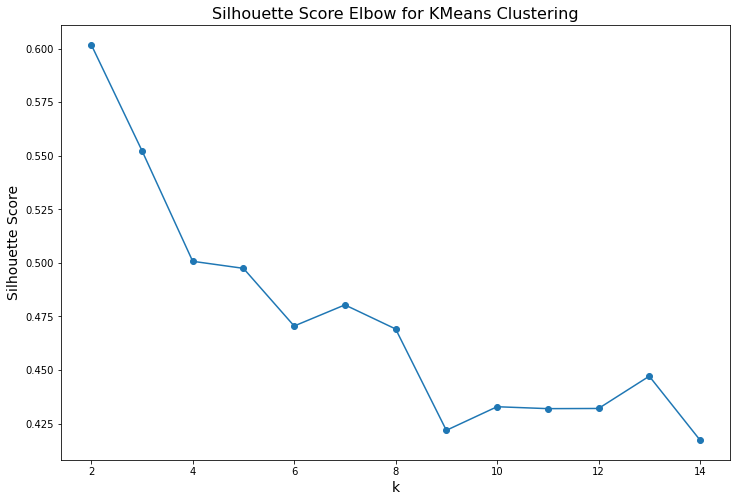

In [ ]:

# Elbow Graph for Silhouette Score

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K[1:15], sil[:13], marker='o')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Silhouette Score', fontsize = 14)
plt.title('Silhouette Score Elbow for KMeans Clustering', fontsize = 16)
plt.show()

In [ ]:

# Setting K = 8

kmeans = KMeans(n_clusters = 8, init = 'k-means++')
kmeans.fit(coordinates)
y = kmeans.labels_
print("k = 8", " silhouette_score ", silhouette_score(coordinates, y, metric='euclidean'))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



k = 8  silhouette_score  0.4704508502740583


In [ ]:

business_final['init_cluster'] = kmeans.predict(business_final[['longitude','latitude']])
business_final.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",4.0,80,39.955505,-75.155564,19107,1
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,"Sushi Bars, Restaurants, Japanese",4.0,245,39.953949,-75.143226,19106,1
2,ROeacJQwBeh05Rqg7F6TCg,BAP,"Korean, Restaurants",4.5,205,39.943223,-75.162568,19147,1
3,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,"Eatertainment, Arts & Entertainment, Brewpubs,...",3.5,65,39.962582,-75.135657,19123,4
4,ppFCk9aQkM338Rgwpl2F5A,Wawa,"Restaurants, Automotive, Delis, Gas Stations, ...",3.0,56,39.954573,-75.194894,19104,2


In [ ]:

# Geographical Plot of 4 Clusters

px.set_mapbox_access_token("pk.eyJ1IjoiY3QzMDU3IiwiYSI6ImNsZmFpN2diMDA1dGQzdG1lNXh4bzYwdmEifQ.Fu4HqAVGPG9XaGVDwEd2pg")
fig = px.scatter_mapbox(business_final, lat="latitude", lon="longitude", color="init_cluster", size='review_count', 
                  hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1000, height=700)

fig.update_layout(mapbox_style="dark")
fig.show()

Based on the above plot, we see that even though there are 4 clusters, the less dense regions have restaurants within clusters that are spread out across long distances. Hence, this might dissuade users from visiting the restaurants that we have recommended if they are too far from his location.

While 4 clusters might seem optimal, in this case, it would be better to have more clusters that are smaller and more spread out across the city of philadelphia.

In [ ]:
# Let's try k = 10

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
kmeans.fit(coordinates)
y = kmeans.labels_
print("k = 10", " silhouette_score ", silhouette_score(coordinates, y, metric='euclidean'))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



k = 10  silhouette_score  0.43245042893162206


In [ ]:

business_final['cluster'] = kmeans.predict(business_final[['longitude','latitude']])
business_final.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",4.0,80,39.955505,-75.155564,19107,1,9
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,"Sushi Bars, Restaurants, Japanese",4.0,245,39.953949,-75.143226,19106,1,9
2,ROeacJQwBeh05Rqg7F6TCg,BAP,"Korean, Restaurants",4.5,205,39.943223,-75.162568,19147,1,9
3,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,"Eatertainment, Arts & Entertainment, Brewpubs,...",3.5,65,39.962582,-75.135657,19123,4,1
4,ppFCk9aQkM338Rgwpl2F5A,Wawa,"Restaurants, Automotive, Delis, Gas Stations, ...",3.0,56,39.954573,-75.194894,19104,2,4


In [ ]:

# Geographical Plot of 4 Clusters

px.set_mapbox_access_token("pk.eyJ1IjoiY3QzMDU3IiwiYSI6ImNsZmFpN2diMDA1dGQzdG1lNXh4bzYwdmEifQ.Fu4HqAVGPG9XaGVDwEd2pg")
fig = px.scatter_mapbox(business_final, lat="latitude", lon="longitude", color="cluster", size='review_count', 
                  hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1000, height=700)

fig.update_layout(mapbox_style="dark")
fig.show()

In [ ]:
# Sort Restaurants based on Stars(rating) and subsequently by Review_count

top_restaurants_philadelphia = business_final.sort_values(by=['stars', 'review_count'], ascending=False)
top_restaurants_philadelphia.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
1647,TE2IEDNV0RcI6s1wTOP4fg,Tortilleria San Roman,"Convenience Stores, Italian, Specialty Food, M...",5.0,219,39.937636,-75.158082,19147,1,9
2793,Ktg3ahIxk0JIkJwXAqu2ew,Hikari Sushi,"Restaurants, Sushi Bars, Japanese",5.0,155,39.967402,-75.141153,19123,4,1
3314,kT8IlV47kz1rz2lTuNyO1w,Christie's Deli,"Restaurants, Breakfast & Brunch, Delis, Sandwi...",5.0,152,39.963081,-75.169360,19130,1,9
2021,UMHuKs1sO-wq3XqKaejXeA,Miss Rachel's Pantry,"Arts & Crafts, Food, Shopping, Food Delivery S...",5.0,119,39.926515,-75.173776,19145,1,8
1880,gvD09Ev1aOmphtlq07zYEA,El Rancho Viejo,"Restaurants, Mexican",5.0,110,39.936282,-75.152142,19147,1,8


In [ ]:
top_restaurants_philadelphia

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
1647,TE2IEDNV0RcI6s1wTOP4fg,Tortilleria San Roman,"Convenience Stores, Italian, Specialty Food, M...",5.0,219,39.937636,-75.158082,19147,1,9
2793,Ktg3ahIxk0JIkJwXAqu2ew,Hikari Sushi,"Restaurants, Sushi Bars, Japanese",5.0,155,39.967402,-75.141153,19123,4,1
3314,kT8IlV47kz1rz2lTuNyO1w,Christie's Deli,"Restaurants, Breakfast & Brunch, Delis, Sandwi...",5.0,152,39.963081,-75.169360,19130,1,9
2021,UMHuKs1sO-wq3XqKaejXeA,Miss Rachel's Pantry,"Arts & Crafts, Food, Shopping, Food Delivery S...",5.0,119,39.926515,-75.173776,19145,1,8
1880,gvD09Ev1aOmphtlq07zYEA,El Rancho Viejo,"Restaurants, Mexican",5.0,110,39.936282,-75.152142,19147,1,8
...,...,...,...,...,...,...,...,...,...,...
1544,8NCYYDGGPtmL4NxQxKUKBA,Burger King,"Fast Food, Burgers, Restaurants",1.0,5,40.044244,-75.101804,19120,0,6
2110,NxB8M1wnJQ5xoXDiUgqmIg,Burger King,"Restaurants, Burgers",1.0,5,40.024678,-75.148695,19140,3,6
2879,usp2gEf_Y2Uf4bxIxET1_g,Geno's Steaks,"Restaurants, Cheesesteaks",1.0,5,39.904389,-75.168915,19148,1,8
3166,rDNXWP86KQj13D4aBT8YJQ,Philly Pretzel Factory,"Restaurants, Bakeries, Food, Pretzels, Ice Cre...",1.0,5,39.999294,-75.229832,19131,6,7


In [ ]:

# Creating Location-Based Recommendation Function
def location_based_recommendation(df, latitude, longitude):
    
    """Predict the cluster for longitude and latitude provided"""
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print("This restaurant belongs to cluster:", cluster)
   
    """Get the best restaurant in this cluster along with the relevant information for a user to make a decision"""
    return df[df['cluster']==cluster].iloc[0:10][['name', 'latitude','longitude','categories','stars', 'review_count','cluster']]
     

In [ ]:
test_coordinates = {
    'user': [1, 2, 3], 
    'latitude' : [40.018890, 43.6701, 43.6546],
    'longitude' : [-75.263759, -79.2988, -79.4452],
}

test_df = pd.DataFrame(test_coordinates)


In [ ]:
user1 = test_df[test_df['user'] == 1]
user1

,user,latitude,longitude
0,1,40.01889,-75.263759


In [ ]:

# Top 10 Recommended Restaurants based on Location at 40.018890, -75.263759

location_based_recommendation(top_restaurants_philadelphia, user1.latitude, user1.longitude)

This restaurant belongs to cluster: 7


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



,name,latitude,longitude,categories,stars,review_count,cluster
1225,New Ridge Brewing,40.034931,-75.217059,"Restaurants, Gastropubs, Breweries, Food",5.0,54,7
1684,Ferrante's Meats & More,39.977642,-75.266764,"Event Planning & Services, Food, Caterers, San...",5.0,24,7
3035,Haggerty Deli,40.029168,-75.225595,"Convenience Stores, Food, Restaurants, Delis",5.0,19,7
2539,Halal Food Truck,40.031943,-75.213393,"Food Trucks, Food, Restaurants, Halal",5.0,14,7
332,Algorithm Restaurants,40.116933,-75.355294,"Food, Food Trucks, Pop-Up Restaurants, Busines...",5.0,10,7
1085,The Basement Board Game Cafe,40.033895,-75.215446,"Cafes, Restaurants, Hobby Shops, Shopping",5.0,8,7
2225,Lucky's Last Chance,40.026304,-75.225536,"Burgers, Pubs, Restaurants, Hot Dogs, Nightlif...",4.5,579,7
166,Smiley's Cafe,40.024774,-75.221435,"Juice Bars & Smoothies, Food, Mediterranean, G...",4.5,423,7
2896,Volo Coffeehouse,40.025517,-75.224097,"Sandwiches, Coffee & Tea, Restaurants, Food",4.5,251,7
3068,Custard & Cakes Creamery,40.023260,-75.207748,"Desserts, Restaurants, Food, Ice Cream & Froze...",4.5,224,7


In [ ]:

# Geographical Plot of Nearby Recommended Restaurants from Royal Ontario Museum

px.set_mapbox_access_token("pk.eyJ1IjoiY3QzMDU3IiwiYSI6ImNsZmFpN2diMDA1dGQzdG1lNXh4bzYwdmEifQ.Fu4HqAVGPG9XaGVDwEd2pg")
fig = px.scatter_mapbox(location_based_recommendation(top_restaurants_philadelphia, user1.latitude, user1.longitude), lat="latitude", lon="longitude",  
                   zoom=10, width=1000, height=700, hover_data= ['name', 'latitude', 'longitude', 'categories', 'stars', 'review_count'])
fig.add_scattermapbox(lat=user1["latitude"], lon= user1["longitude"]).update_traces(dict(mode='markers', marker = dict(size = 15)))
fig.update_layout(mapbox_style="dark")

This restaurant belongs to cluster: 7


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



Collaborative-Filtering Recommendation System
Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users.

It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions.

In [ ]:
final_reviews.head(3)


,business_id,review_id,user_id,stars,useful,funny,cool,text,date,word_count,char_count,avg_word_len,stopword_count,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,compound_score,sentiment,Dominant_Topic,Keywords,Text_Chunks,super_score
0,cPDX2Y4H0fks-Qj5tfBduA,YP4dpdLt7iomIJGIweKTjg,K97i0e7MaxYfvCCwPFMjuw,3.0,0.0,0.0,0.0,This is solely for the cupcakes. So I retuned ...,2011-07-24 17:44:29,109.0,582.0,4.348624,44.0,solely cupcakes retuned tartes sweet treats co...,-0.060185,0.304630,0.074,0.844,0.082,-0.0066,-0.0066,neutral,2.0,"pizza, cake, wing, chocolate, ice, pie, cream,...","['solely', 'cupcake', 'retune', 'tarte', 'swee...",3.000397
1,cPDX2Y4H0fks-Qj5tfBduA,Dsz8hsLQNDJntT45PxG4HQ,ubPlKiHayyv2puouC1faMQ,5.0,0.0,0.0,0.0,An enchantingly wonderful happy place! Tartes...,2016-03-04 23:56:35,48.0,264.0,4.617021,17.0,enchantingly wonderful happy place tartes favo...,0.500000,0.800000,0.000,0.662,0.338,0.9682,0.9682,positive,4.0,"place, food, great, service, price, really, we...","['enchantingly', 'wonderful', 'happy', 'place'...",5.484100
2,cPDX2Y4H0fks-Qj5tfBduA,d6HqIoLPBkBGE_eME6P3aA,0ENLV8uFNuZEehc48HwYzw,5.0,1.0,0.0,1.0,"Perfect coconut, key lime and apple crumb tart...",2012-04-14 19:32:15,54.0,302.0,4.611111,18.0,perfect coconut key lime apple crumb tarts alw...,0.334375,0.634615,0.016,0.727,0.257,0.9507,0.9507,positive,4.0,"place, food, great, service, price, really, we...","['perfect', 'coconut', 'key', 'lime', 'apple',...",5.317890


In [ ]:
business_final.head(3)


,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",4.0,80,39.955505,-75.155564,19107,1,9
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,"Sushi Bars, Restaurants, Japanese",4.0,245,39.953949,-75.143226,19106,1,9
2,ROeacJQwBeh05Rqg7F6TCg,BAP,"Korean, Restaurants",4.5,205,39.943223,-75.162568,19147,1,9


In [ ]:

# Filtering for Selected Columns

final_df = final_reviews[['business_id', 'user_id', 'super_score', 'Keywords', 'stars']]
final_df.head(3)

,business_id,user_id,super_score,Keywords,stars
0,cPDX2Y4H0fks-Qj5tfBduA,K97i0e7MaxYfvCCwPFMjuw,3.000397,"pizza, cake, wing, chocolate, ice, pie, cream,...",3.0
1,cPDX2Y4H0fks-Qj5tfBduA,ubPlKiHayyv2puouC1faMQ,5.484100,"place, food, great, service, price, really, we...",5.0
2,cPDX2Y4H0fks-Qj5tfBduA,0ENLV8uFNuZEehc48HwYzw,5.317890,"place, food, great, service, price, really, we...",5.0


In [ ]:

philadelphia_restaurant = business_final[['business_id', 'name', 'categories']]
philadelphia_restaurant.head()

,business_id,name,categories
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,"Sushi Bars, Restaurants, Japanese"
2,ROeacJQwBeh05Rqg7F6TCg,BAP,"Korean, Restaurants"
3,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,"Eatertainment, Arts & Entertainment, Brewpubs,..."
4,ppFCk9aQkM338Rgwpl2F5A,Wawa,"Restaurants, Automotive, Delis, Gas Stations, ..."


In [ ]:

# Merging Dataframes

philadelphia_data = pd.merge(final_df, philadelphia_restaurant, on='business_id')
philadelphia_data.head(5)

,business_id,user_id,super_score,Keywords,stars,name,categories
0,cPDX2Y4H0fks-Qj5tfBduA,K97i0e7MaxYfvCCwPFMjuw,3.000397,"pizza, cake, wing, chocolate, ice, pie, cream,...",3.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants"
1,cPDX2Y4H0fks-Qj5tfBduA,ubPlKiHayyv2puouC1faMQ,5.484100,"place, food, great, service, price, really, we...",5.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants"
2,cPDX2Y4H0fks-Qj5tfBduA,0ENLV8uFNuZEehc48HwYzw,5.317890,"place, food, great, service, price, really, we...",5.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants"
3,cPDX2Y4H0fks-Qj5tfBduA,ouODopBKF3AqfCkuQEnrDg,5.419092,"pizza, cake, wing, chocolate, ice, pie, cream,...",5.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants"
4,cPDX2Y4H0fks-Qj5tfBduA,jGUdsAMkurKYZCh6l84n7w,4.000000,"order, time, wait, food, give, ask, never, bad...",4.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants"


In [ ]:
philadelphia_data.head()

,business_id,user_id,super_score,Keywords,stars,name,categories
0,cPDX2Y4H0fks-Qj5tfBduA,K97i0e7MaxYfvCCwPFMjuw,3.000397,"pizza, cake, wing, chocolate, ice, pie, cream,...",3.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants"
1,cPDX2Y4H0fks-Qj5tfBduA,ubPlKiHayyv2puouC1faMQ,5.484100,"place, food, great, service, price, really, we...",5.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants"
2,cPDX2Y4H0fks-Qj5tfBduA,0ENLV8uFNuZEehc48HwYzw,5.317890,"place, food, great, service, price, really, we...",5.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants"
3,cPDX2Y4H0fks-Qj5tfBduA,ouODopBKF3AqfCkuQEnrDg,5.419092,"pizza, cake, wing, chocolate, ice, pie, cream,...",5.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants"
4,cPDX2Y4H0fks-Qj5tfBduA,jGUdsAMkurKYZCh6l84n7w,4.000000,"order, time, wait, food, give, ask, never, bad...",4.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants"


In [ ]:

philadelphia_data.to_csv("/content/gdrive/MyDrive/restaurant recomendation system/philadelphia_data.csv")

In [ ]:

# Combining the text in Keywords and categories columns
philadelphia_data['All_Keywords'] = philadelphia_data['categories'].str.cat(philadelphia_data['Keywords'],sep=", ")
philadelphia_data.head()

,business_id,user_id,super_score,Keywords,stars,name,categories,All_Keywords
0,cPDX2Y4H0fks-Qj5tfBduA,K97i0e7MaxYfvCCwPFMjuw,3.000397,"pizza, cake, wing, chocolate, ice, pie, cream,...",3.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants","Desserts, Bakeries, Food, Restaurants, pizza, ..."
1,cPDX2Y4H0fks-Qj5tfBduA,ubPlKiHayyv2puouC1faMQ,5.484100,"place, food, great, service, price, really, we...",5.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants","Desserts, Bakeries, Food, Restaurants, place, ..."
2,cPDX2Y4H0fks-Qj5tfBduA,0ENLV8uFNuZEehc48HwYzw,5.317890,"place, food, great, service, price, really, we...",5.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants","Desserts, Bakeries, Food, Restaurants, place, ..."
3,cPDX2Y4H0fks-Qj5tfBduA,ouODopBKF3AqfCkuQEnrDg,5.419092,"pizza, cake, wing, chocolate, ice, pie, cream,...",5.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants","Desserts, Bakeries, Food, Restaurants, pizza, ..."
4,cPDX2Y4H0fks-Qj5tfBduA,jGUdsAMkurKYZCh6l84n7w,4.000000,"order, time, wait, food, give, ask, never, bad...",4.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants","Desserts, Bakeries, Food, Restaurants, order, ..."


In [ ]:

# Sanity Check
philadelphia_data.All_Keywords.head(1)

0    Desserts, Bakeries, Food, Restaurants, pizza, ...
Name: All_Keywords, dtype: object

In [ ]:

# Top Restaurants in philadelphia based on Super Score Rating
philadelphia_data.groupby('name')['super_score'].mean().sort_values(ascending = False).head()

name
Musette                  5.549023
Jamils Cafe On Wheels    5.430497
Marianna's Pizzeria      5.380845
Salam Cafe and Market    5.374402
Chestnut Hill Sushi      5.353884
Name: super_score, dtype: float64

In [ ]:


# Restaurants in philadelphia with the highest number of Yelp Reviews
philadelphia_data.groupby('name')['super_score'].count().sort_values(ascending = False).head()

name
Zahav                             2838
Dalessandro’s Steaks & Hoagies    2264
Sonny's Famous Steaks             1518
Parc                              1447
Sabrina's Café                    1278
Name: super_score, dtype: int64

In [ ]:

# Creating the Matrix by using the Pivot Table Function
philadelphia_restaurant_rating = philadelphia_data.pivot_table(index = 'user_id', columns = 'name', values = 'super_score')
philadelphia_restaurant_rating.head()

name,&pizza - Walnut,17 Snyder Chinese,1st NE International Market,20th Street Pizza,4 Seasons Food Market,52nd Station Diner,A & J Seafood,A La Mousse,A P J Texas Weiner,A Taste O' Home,A.Cafe AKA Cafe,Abyssinia,Aldo and Manny Pizza and Pasta,Alimentari,Alma Del Mar,Alyan's Restaurant,Amada,Amazing Crab House,Ambassador,AmeriThai,America's Best Wings,Amuse,Andy's Chicken,Angela's Pizza,Anna Restaurant,...,Vito's Pizza & Grill,Voltage Lounge,Volvér,Wacky Zaki's,Wawa,Win Win,Wingstop,Winkel,Winnie's Manayunk,Wokano,Wolf Street Pizza & Grill,Woodrow's Sandwich Shop,Wrap Shack,Wynnefield Pizza,Xin Xing House,Yards Brewing Company,Yeeroh,Yiro Yiro,Zaffron,Zahav,Zuzu's Kitchen,bāo•logy,chili's,honeygrow,revive 21
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--4_p6Z3tKadJcr9Non_Vw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--6PFZka7og6Khaw6oyjvQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--9SwR3jQX-e3opxARFF_g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--B0My3yotQA2kLVWz6IYA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--CiqXBj69Uu4YN1WTQ82Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Normalizing the Rating Scores

def mean_center_rows(df):
    return (df.T - df.mean(axis = 1)).T

philadelphia_restaurant_rating = mean_center_rows(philadelphia_restaurant_rating)
philadelphia_restaurant_rating.head()

name,&pizza - Walnut,17 Snyder Chinese,1st NE International Market,20th Street Pizza,4 Seasons Food Market,52nd Station Diner,A & J Seafood,A La Mousse,A P J Texas Weiner,A Taste O' Home,A.Cafe AKA Cafe,Abyssinia,Aldo and Manny Pizza and Pasta,Alimentari,Alma Del Mar,Alyan's Restaurant,Amada,Amazing Crab House,Ambassador,AmeriThai,America's Best Wings,Amuse,Andy's Chicken,Angela's Pizza,Anna Restaurant,...,Vito's Pizza & Grill,Voltage Lounge,Volvér,Wacky Zaki's,Wawa,Win Win,Wingstop,Winkel,Winnie's Manayunk,Wokano,Wolf Street Pizza & Grill,Woodrow's Sandwich Shop,Wrap Shack,Wynnefield Pizza,Xin Xing House,Yards Brewing Company,Yeeroh,Yiro Yiro,Zaffron,Zahav,Zuzu's Kitchen,bāo•logy,chili's,honeygrow,revive 21
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--4_p6Z3tKadJcr9Non_Vw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--6PFZka7og6Khaw6oyjvQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--9SwR3jQX-e3opxARFF_g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--B0My3yotQA2kLVWz6IYA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--CiqXBj69Uu4YN1WTQ82Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Filling all Null Values with 0.0

philadelphia_restaurant_rating = philadelphia_restaurant_rating.fillna(0)
philadelphia_restaurant_rating.head()

name,&pizza - Walnut,17 Snyder Chinese,1st NE International Market,20th Street Pizza,4 Seasons Food Market,52nd Station Diner,A & J Seafood,A La Mousse,A P J Texas Weiner,A Taste O' Home,A.Cafe AKA Cafe,Abyssinia,Aldo and Manny Pizza and Pasta,Alimentari,Alma Del Mar,Alyan's Restaurant,Amada,Amazing Crab House,Ambassador,AmeriThai,America's Best Wings,Amuse,Andy's Chicken,Angela's Pizza,Anna Restaurant,...,Vito's Pizza & Grill,Voltage Lounge,Volvér,Wacky Zaki's,Wawa,Win Win,Wingstop,Winkel,Winnie's Manayunk,Wokano,Wolf Street Pizza & Grill,Woodrow's Sandwich Shop,Wrap Shack,Wynnefield Pizza,Xin Xing House,Yards Brewing Company,Yeeroh,Yiro Yiro,Zaffron,Zahav,Zuzu's Kitchen,bāo•logy,chili's,honeygrow,revive 21
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--4_p6Z3tKadJcr9Non_Vw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--6PFZka7og6Khaw6oyjvQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--9SwR3jQX-e3opxARFF_g,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--B0My3yotQA2kLVWz6IYA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--CiqXBj69Uu4YN1WTQ82Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

# Check Mean scores across user_ids

philadelphia_restaurant_rating.mean(axis=1)

user_id
--4_p6Z3tKadJcr9Non_Vw    0.000000e+00
--6PFZka7og6Khaw6oyjvQ    0.000000e+00
--9SwR3jQX-e3opxARFF_g    0.000000e+00
--B0My3yotQA2kLVWz6IYA    0.000000e+00
--CiqXBj69Uu4YN1WTQ82Q    0.000000e+00
                              ...     
zzW1NTuShpLFy-4zPFbggw    1.323664e-18
zzeRWIiPtuJNRBUcxe0Upw    6.618319e-19
zziJLt25YU6dp01sewR-IQ    0.000000e+00
zzwYLnmIvj8C7wJmRjtkRA    0.000000e+00
zzx7J3zheFF3zf5YYfDAMg    0.000000e+00
Length: 48184, dtype: float64

In [ ]:
philadelphia_restaurant_rating.mean(axis=1).isnull().sum()

0

In [ ]:

# Check Mean scores across business_ids
philadelphia_restaurant_rating.mean(axis = 0)

name
&pizza - Walnut                0.000705
17 Snyder Chinese             -0.000063
1st NE International Market   -0.000016
20th Street Pizza              0.000125
4 Seasons Food Market          0.000008
                                 ...   
Zuzu's Kitchen                 0.000143
bāo•logy                      -0.000374
chili's                       -0.000138
honeygrow                     -0.000399
revive 21                     -0.000021
Length: 671, dtype: float64

In [ ]:

philadelphia_restaurant_rating.mean(axis = 0).isnull().sum()

0

Cosine Similarity
The cosine similarity between the user profile and all item profiles is computed to establish each user's preference. Cosine similarity measures the similarity between two vectors by calculating the cosine of the angle between them. It is the dot product of two vectors divided by the product of the magnitude of each vector. As the dot product is divided by the magnitude, data is normalised and only the angle difference is measured. The cosine similarity of each restaurant to each user is calculated. The cosine of a 0 degree angle is 1, therefore the closer to 1 the cosine similarity is, the more similar the items are.

In [ ]:

# Overview of Matrix - #74,515 rows of User_ids, 4,257 columns of Restaurants

print(philadelphia_restaurant_rating.shape)
philadelphia_restaurant_rating

(48184, 671)


name,&pizza - Walnut,17 Snyder Chinese,1st NE International Market,20th Street Pizza,4 Seasons Food Market,52nd Station Diner,A & J Seafood,A La Mousse,A P J Texas Weiner,A Taste O' Home,A.Cafe AKA Cafe,Abyssinia,Aldo and Manny Pizza and Pasta,Alimentari,Alma Del Mar,Alyan's Restaurant,Amada,Amazing Crab House,Ambassador,AmeriThai,America's Best Wings,Amuse,Andy's Chicken,Angela's Pizza,Anna Restaurant,...,Vito's Pizza & Grill,Voltage Lounge,Volvér,Wacky Zaki's,Wawa,Win Win,Wingstop,Winkel,Winnie's Manayunk,Wokano,Wolf Street Pizza & Grill,Woodrow's Sandwich Shop,Wrap Shack,Wynnefield Pizza,Xin Xing House,Yards Brewing Company,Yeeroh,Yiro Yiro,Zaffron,Zahav,Zuzu's Kitchen,bāo•logy,chili's,honeygrow,revive 21
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--4_p6Z3tKadJcr9Non_Vw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--6PFZka7og6Khaw6oyjvQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--9SwR3jQX-e3opxARFF_g,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--B0My3yotQA2kLVWz6IYA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--CiqXBj69Uu4YN1WTQ82Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzW1NTuShpLFy-4zPFbggw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zzeRWIiPtuJNRBUcxe0Upw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zziJLt25YU6dp01sewR-IQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

# Converting the Matrix DataFrame into a NumPy array

philadelphia_matrix = philadelphia_restaurant_rating.to_numpy()
philadelphia_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Truncated SVD
When it comes to matrix factorization technique, truncated Singular Value Decomposition (SVD) is a popular method to produce features that factors a matrix M into the three matrices U, Σ, and V. Truncated SVD shares similarity with Principal Component Analysis while SVD is produced from the data matrix and the factorization of PCA is generated from the covariance matrix.

Unlike regular SVDs, truncated SVD produces a factorization where the number of columns can be specified for a number of truncation. For example, given an n x n matrix, truncated SVD generates the matrices with the specified number of columns, whereas SVD outputs n columns of matrices. Truncated SVD can deal with sparse matrix to generate features’ matrices, whereas PCA would operate on the entire matrix for the output of the covariance matrix.

In [ ]:

# Applying Singular Value Decomposition (SVD)

#The number of factors to factor the user-item matrix.

NUMBER_OF_FACTORS_MF = 15

#Performs matrix factorization of the original user item matrix

U, sigma, Vt = svds(philadelphia_matrix, k = NUMBER_OF_FACTORS_MF)

print(U.shape)
print(Vt.shape)

sigma = np.diag(sigma)
sigma.shape

(48184, 15)
(15, 671)


(15, 15)

After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations

In [ ]:

# Overview of user ratings across all Restaurants in philadelphia

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings


array([[ 1.78867809e-17,  3.35108187e-18,  2.30550267e-20, ...,
         1.15703923e-18, -3.14761535e-18, -1.23128140e-18],
       [ 1.36517884e-17,  4.01505346e-18, -4.85340317e-20, ...,
        -1.64738157e-18,  1.67147287e-18, -7.18756267e-19],
       [-1.84098563e-17, -5.36453567e-19,  4.77248036e-20, ...,
        -5.42175951e-19,  8.47394832e-18, -1.01210394e-18],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [ ]:

# Converting the reconstructed matrix back to a Pandas dataframe
# List of first 10 Yelp Customer User_ids in the Matrix
user_ids = list(philadelphia_restaurant_rating.index)

cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = philadelphia_restaurant_rating.columns, index=user_ids).transpose()
print(cf_preds_df.shape)
cf_preds_df
     

(671, 48184)


,--4_p6Z3tKadJcr9Non_Vw,--6PFZka7og6Khaw6oyjvQ,--9SwR3jQX-e3opxARFF_g,--B0My3yotQA2kLVWz6IYA,--CiqXBj69Uu4YN1WTQ82Q,--Dq76pp192-Wk-vo_dPmg,--Dz7-yZ5vMuDdlHxfBWVw,--FxiKq-x-zu-tfn4F55DA,--Qos7f808A7REJPzSZ5Og,--QuTu4oQehIyk8VCaLVFQ,--UhENQdbuWEh0mU5weIEg,--YFsSwR8YRhFwwv9ZkKBw,--YWBD-491bjkqJWEUGaDg,--cjT1ICjm_ajiwSKoCC7g,--pMssoWlOqX0pLiPMiZZw,--qijw7qsKsG-v6rreDOAA,-0-l5jAPp9G8X_m8RkQbBA,-00EEl_njt2H59lNgcsi0w,-00gWMLJq2BKx0kjL9-eow,-03y31IzykunU9azzgLsoQ,-0L0gIX_mBjP77ZRfLZfdA,-0MIp6WKJ8QvGnYZQ5ETyg,-0TIxezdO7xXrkP7zXFd8Q,-0aInSHjCWLfiNqfgmWnow,-0rQkv0XBoIWooPiTST00A,...,zxsrz56SmYhaTbnk9BqFzA,zxzSZi-jrGWOuJagToQRGg,zy1CuLKzsy4WTggLOmRv5Q,zy7ul0w2K5S4RVi0urtQKw,zyCR2yVtg8D7e_mutOLwjA,zyK9QAo-lPW415tfc166GQ,zyNrXvJyYdC34tS6BcCykA,zySfwbIHPNhLR8-JiqGdWA,zyWO2mxzHsVZhPcRnfsTfA,zyfS9KhQmDUmGAuwyHlt6g,zyjzkLBrYJO5mYQ7sEGhNA,zynfOy36AZ0WsoGUYAjQaA,zzBhA0M7NNBMYoWj48h53A,zzCXtfNF58BN4VzrgqyEqg,zzFGYS2L2iY3xHsYci9ZJw,zzIhKazCpzGUrIrM7izSig,zzJPmRrEMNzCZJkXPRpGZw,zzMd5A98PXaxUf8DOsgd4w,zzSSEPbr4hkvPBOq1ZM9Yw,zzSiUxBTpvLyOKWVohcD-w,zzW1NTuShpLFy-4zPFbggw,zzeRWIiPtuJNRBUcxe0Upw,zziJLt25YU6dp01sewR-IQ,zzwYLnmIvj8C7wJmRjtkRA,zzx7J3zheFF3zf5YYfDAMg
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
&pizza - Walnut,1.788678e-17,1.365179e-17,-1.840986e-17,2.723333e-17,-4.085572e-17,3.292864e-18,1.154719e-17,-4.675097e-18,-1.168028e-17,5.119590e-18,-6.412862e-19,-1.523380e-18,3.129242e-18,-1.359798e-19,0.0,0.0,-0.008543,0.0,0.0,0.0,0.0,0.0,0.0,0.000368,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001769,0.0,0.0,-0.019440,0.0,0.0,0.003303,-7.125178e-05,0.0,0.0,0.0,0.0,0.0,0.0,-2.574106e-05,-0.000063,0.0,0.0,0.0
17 Snyder Chinese,3.351082e-18,4.015053e-18,-5.364536e-19,1.941677e-18,-5.943579e-18,-1.705864e-18,-4.228702e-18,-2.396348e-18,6.421330e-19,6.538728e-19,1.320797e-19,8.319838e-20,-4.141334e-20,3.560552e-21,0.0,0.0,0.000088,0.0,0.0,0.0,0.0,0.0,0.0,-0.000389,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.000502,0.0,0.0,0.000473,0.0,0.0,0.000177,-5.140114e-06,0.0,0.0,0.0,0.0,0.0,0.0,-3.346793e-05,0.000017,0.0,0.0,0.0
1st NE International Market,2.305503e-20,-4.853403e-20,4.772480e-20,-5.954815e-20,8.373425e-20,1.880803e-20,-1.682149e-21,-1.295394e-21,1.310600e-20,1.494044e-20,4.454346e-21,5.397042e-22,-2.495750e-21,7.175372e-23,0.0,0.0,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,0.000006,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.000006,0.0,0.0,-0.000027,0.0,0.0,-0.000014,5.395260e-07,0.0,0.0,0.0,0.0,0.0,0.0,-4.370205e-07,-0.000005,0.0,0.0,0.0
20th Street Pizza,2.331709e-18,-6.066570e-19,2.282934e-18,-1.898188e-19,-1.024761e-18,-1.776744e-18,1.223603e-18,9.878081e-19,-1.040242e-18,-2.010462e-19,-7.335407e-19,4.293827e-20,-3.543421e-20,-5.720997e-21,0.0,0.0,0.000142,0.0,0.0,0.0,0.0,0.0,0.0,-0.000103,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000319,0.0,0.0,-0.001540,0.0,0.0,0.000448,-1.882277e-05,0.0,0.0,0.0,0.0,0.0,0.0,-2.785567e-04,0.000002,0.0,0.0,0.0
4 Seasons Food Market,-9.535265e-19,2.255559e-19,-8.472500e-19,5.690124e-19,1.385367e-19,-2.854344e-19,7.843405e-19,-1.093257e-19,-7.589600e-19,-1.527280e-19,-4.439507e-20,-1.188285e-19,4.143547e-19,-1.083703e-21,0.0,0.0,-0.001141,0.0,0.0,0.0,0.0,0.0,0.0,0.000021,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000024,0.0,0.0,-0.001476,0.0,0.0,0.000017,-3.123632e-06,0.0,0.0,0.0,0.0,0.0,0.0,5.554141e-05,-0.000058,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zuzu's Kitchen,-6.698094e-18,-1.499463e-18,1.670123e-18,-8.992604e-19,6.943533e-19,-3.153549e-20,-3.621746e-18,8.134736e-19,4.526208e-18,-6.675079e-19,1.027408e-18,-6.459915e-19,1.010778e-19,2.661917e-20,0.0,0.0,0.000354,0.0,0.0,0.0,0.0,0.0,0.0,-0.000123,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.000930,0.0,0.0,-0.000762,0.0,0.0,-0.000232,5.883858e-06,0.0,0.0,0.0,0.0,0.0,0.0,-2.199811e-05,0.000048,0.0,0.0,0.0
bāo•logy,-2.106096e-17,-1.016042e-17,1.240321e-17,-1.907689e-17,2.841601e-17,-7.548575e-18,-8.990638e-18,-4.097034e-20,2.53823

In [ ]:

# Creating Item-Item Matrix based on Cosine Similarity

item_item_matrix = cosine_similarity(cf_preds_df)
item_item_matrix= pd.DataFrame(item_item_matrix, columns=cf_preds_df.index, index = cf_preds_df.index)
item_item_matrix

name,&pizza - Walnut,17 Snyder Chinese,1st NE International Market,20th Street Pizza,4 Seasons Food Market,52nd Station Diner,A & J Seafood,A La Mousse,A P J Texas Weiner,A Taste O' Home,A.Cafe AKA Cafe,Abyssinia,Aldo and Manny Pizza and Pasta,Alimentari,Alma Del Mar,Alyan's Restaurant,Amada,Amazing Crab House,Ambassador,AmeriThai,America's Best Wings,Amuse,Andy's Chicken,Angela's Pizza,Anna Restaurant,...,Vito's Pizza & Grill,Voltage Lounge,Volvér,Wacky Zaki's,Wawa,Win Win,Wingstop,Winkel,Winnie's Manayunk,Wokano,Wolf Street Pizza & Grill,Woodrow's Sandwich Shop,Wrap Shack,Wynnefield Pizza,Xin Xing House,Yards Brewing Company,Yeeroh,Yiro Yiro,Zaffron,Zahav,Zuzu's Kitchen,bāo•logy,chili's,honeygrow,revive 21
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
&pizza - Walnut,1.000000,0.342851,-0.275509,0.159047,0.537195,0.014739,0.160041,0.225263,0.021996,-0.143709,0.046820,-0.043639,-0.166948,0.209514,0.193398,-0.301667,-0.216841,0.279028,0.250254,0.051308,0.162141,0.194713,0.044347,-0.264921,0.038981,...,-0.605318,0.042521,-0.371226,0.022737,-0.232701,-0.035777,0.106119,0.313130,-0.547157,-0.068244,-0.420020,-0.190154,-0.461841,0.203597,0.061129,0.209395,-0.453199,0.286548,0.001118,0.236027,-0.275517,-0.788633,-0.010124,-0.392061,-0.141643
17 Snyder Chinese,0.342851,1.000000,-0.204814,-0.256959,-0.209706,-0.245696,-0.038832,-0.204089,-0.200226,0.091623,0.024412,-0.205530,0.059113,-0.378536,-0.067857,0.158212,0.070224,-0.106706,0.154216,0.021818,0.130920,-0.000822,0.270109,-0.238343,-0.122943,...,-0.086354,0.749719,0.252728,0.451614,-0.003275,-0.398840,0.257780,-0.111821,0.187740,0.108683,-0.267004,-0.234156,0.020309,0.242468,0.070652,-0.016401,0.072368,0.273298,0.315519,-0.026006,-0.169000,-0.106601,-0.097226,0.316477,-0.067040
1st NE International Market,-0.275509,-0.204814,1.000000,-0.269926,-0.141733,0.593829,-0.043539,-0.198161,0.053671,0.085381,-0.529895,-0.033219,0.142363,-0.054975,0.290655,-0.157540,-0.110457,-0.539117,-0.483102,0.266265,0.070245,-0.150054,-0.450745,0.498187,-0.024421,...,0.207794,0.136079,0.286734,-0.032416,-0.143662,-0.377356,-0.373478,-0.364712,0.111477,0.100049,0.210366,0.090176,-0.362532,-0.261209,-0.091928,0.176987,0.273377,-0.049119,-0.002348,-0.030261,0.145560,0.568850,-0.228089,-0.078428,-0.158302
20th Street Pizza,0.159047,-0.256959,-0.269926,1.000000,0.221976,-0.071738,0.133071,-0.111870,0.376528,0.184263,0.080320,0.124491,-0.316484,0.114570,-0.000226,-0.206704,0.043236,-0.218694,0.449499,0.039729,0.138999,0.110312,0.274104,-0.060139,-0.118249,...,-0.036658,-0.156743,-0.110133,-0.195571,-0.110046,0.378853,-0.026717,-0.031862,-0.379430,0.292050,-0.167902,-0.273183,0.160142,0.063266,-0.044545,-0.006015,-0.342327,0.071380,-0.320532,0.071118,-0.313882,-0.403061,-0.180144,-0.022786,-0.069323
4 Seasons Food Market,0.537195,-0.209706,-0.141733,0.221976,1.000000,0.246793,0.376344,-0.034802,-0.219097,-0.360403,0.086594,0.079086,-0.318597,0.316140,0.397035,-0.073855,0.019282,-0.023635,-0.254542,0.026292,-0.073753,0.101191,-0.117762,-0.376305,0.209705,...,-0.375254,-0.470077,-0.310874,-0.113802,-0.221869,0.335306,0.216863,0.277273,-0.377138,-0.259959,-0.000608,0.287194,-0.502762,-0.178408,-0.015042,-0.017904,-0.593868,0.135607,-0.055966,0.019854,0.062152,-0.399303,0.215817,-0.364854,-0.132414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zuzu's Kitchen,-0.275517,-0.169000,0.145560,-0.313882,0.062152,0.282852,-0.005350,-0.074349,-0.319422,0.011408,-0.017047,0.443333,0.054408,0.269814,0.002905,0.318783,0.158711,0.075484,-0.316627,0.322421,-0.020105,-0.058319,-0.260035,0.215577,-0.062849,...,-0.130510,-0.118171,-0.381621,-0.012983,0.202306,-0.139093,0.254974,0.005404,0.148417,0.117293,0.607503,0.281065,-0.172126,-0.135574,0.063723,0.149806,0.284334,-0.170848,0.045591,-0.224633,1.000000,0.189030,0.692984,0.246941,-0.016519
bāo•logy,-0.788633,

In [ ]:
# Creating Collaborative Filtering Function for Restaurant-Restaurant Recommendation System

def cf_recommender(restaurant):
    
    """Getting the correlation of a specific restaurant with other philadelphia Restaurants"""
    restaurant_ratings = cf_preds_df.T[restaurant]
    similar_restaurant_ratings = cf_preds_df.T.corrwith(restaurant_ratings)
    corr_ratings = pd.DataFrame(similar_restaurant_ratings, columns=['Correlation'])
    corr_ratings.dropna(inplace=True)
    
    """Retrieving the Ratings Scores from the Item-Item Matrix"""
    ratings_sim = item_item_matrix[restaurant]
    
    """Filtering for positively correlated restaurants"""
    ratings_sim = ratings_sim[ratings_sim>0]
    
    """Generate Top 10 Recommended Restaurants"""
    """Exclude top row as that will be the same restaurant"""
    return ratings_sim.sort_values(ascending= False).head(11)[1:]


Let's test out our Collaborative Filtering Model on 2 Restaurants: zahav, which has the highest number of Yelp Reviews, and Sabor Del Pacifico, which has the highest overall Super Score Rating.

In [ ]:

# Top 10 Recommended Restaurants that people should visit if they had previously visited Pai Northern Thai Kitchen

restaurant_recommendations = cf_recommender('Zahav')
restaurant_recommendations = pd.DataFrame(data = restaurant_recommendations)
restaurant_recommendations

,Zahav
name,
The Little Sicilian Food Truck,0.639038
The Crimson Cafe,0.616225
Jembatan 5,0.569827
Goldie,0.444665
Tropical Smoothie Cafe,0.433393
Honey Bee Gourmet Deli,0.426178
Fu-Wah Mini Market,0.421035
Casa México,0.399332
Salt & Pepper Deli III,0.397529


In [ ]:

restaurant = philadelphia_data[philadelphia_data['name'] == 'Zahav'][['name','categories','super_score']]
restaurant.head()

,name,categories,super_score
37406,Zahav,"Nightlife, Bars, Food, Ethnic Food, Middle Eas...",5.386913
37407,Zahav,"Nightlife, Bars, Food, Ethnic Food, Middle Eas...",5.252783
37408,Zahav,"Nightlife, Bars, Food, Ethnic Food, Middle Eas...",5.118739
37409,Zahav,"Nightlife, Bars, Food, Ethnic Food, Middle Eas...",5.300982
37410,Zahav,"Nightlife, Bars, Food, Ethnic Food, Middle Eas...",5.178498


In [ ]:
restaurant_1 = philadelphia_data[philadelphia_data['name'] == 'The Little Sicilian Food Truck'][['name','categories','super_score']]
restaurant_1.head()

,name,categories,super_score
46271,The Little Sicilian Food Truck,"Food, Food Trucks, Restaurants, Caterers, Even...",3.079621
46272,The Little Sicilian Food Truck,"Food, Food Trucks, Restaurants, Caterers, Even...",2.149828
46273,The Little Sicilian Food Truck,"Food, Food Trucks, Restaurants, Caterers, Even...",5.292290
46274,The Little Sicilian Food Truck,"Food, Food Trucks, Restaurants, Caterers, Even...",2.005136
46275,The Little Sicilian Food Truck,"Food, Food Trucks, Restaurants, Caterers, Even...",2.020765


In [ ]:
restaurant_2 = philadelphia_data[philadelphia_data['name'] == 'The Crimson Cafe'][['name','categories','super_score']]
restaurant_2.head()

,name,categories,super_score
58539,The Crimson Cafe,"Restaurants, Soul Food, Southern",5.495600
58540,The Crimson Cafe,"Restaurants, Soul Food, Southern",5.220850
58541,The Crimson Cafe,"Restaurants, Soul Food, Southern",5.319491
58542,The Crimson Cafe,"Restaurants, Soul Food, Southern",5.339512
58543,The Crimson Cafe,"Restaurants, Soul Food, Southern",5.133076


In [ ]:
restaurant_3 = philadelphia_data[philadelphia_data['name'] == 'Jembatan 5'][['name','categories','super_score']]
restaurant_3.head()

,name,categories,super_score
4346,Jembatan 5,"Indonesian, Restaurants",5.131071
4347,Jembatan 5,"Indonesian, Restaurants",4.241705
4348,Jembatan 5,"Indonesian, Restaurants",5.228968
4349,Jembatan 5,"Indonesian, Restaurants",5.311189
4350,Jembatan 5,"Indonesian, Restaurants",5.365055


Based on these observations, Pai Northern Thai Kitchen is classified as a Thai Restaurant, whereas the top 3 recommended restaurants are classified as Bakeries, Chinese, Indian types of Restaurants respectively.

Case Study 2: 

In [ ]:

# Top 10 Recommended Restaurants that people should visit if they had previously visited Sabor Del Pacifico

restaurant_recommendations = cf_recommender('Dalessandro’s Steaks & Hoagies')
restaurant_recommendations = pd.DataFrame(data = restaurant_recommendations)
restaurant_recommendations

,Dalessandro’s Steaks & Hoagies
name,
Bally Pizza,0.997684
New Era Indian Cuisine,0.993734
Hong Kong Deli,0.940020
Halal Fusion Chinese Restaurant,0.839329
Angela's Pizza,0.778597
Chris's Pizza,0.772497
Germantown Garden,0.660264
Murphy's Tavern,0.651091
Shanks Original,0.613389


In [ ]:
restaurant= philadelphia_data[philadelphia_data['name'] == 'Dalessandro’s Steaks & Hoagies'][['name','categories','super_score']]
restaurant.head()

,name,categories,super_score
56077,Dalessandro’s Steaks & Hoagies,"Sandwiches, Delis, Restaurants, Cheesesteaks",5.877900
56078,Dalessandro’s Steaks & Hoagies,"Sandwiches, Delis, Restaurants, Cheesesteaks",3.349398
56079,Dalessandro’s Steaks & Hoagies,"Sandwiches, Delis, Restaurants, Cheesesteaks",5.067890
56080,Dalessandro’s Steaks & Hoagies,"Sandwiches, Delis, Restaurants, Cheesesteaks",5.382140
56081,Dalessandro’s Steaks & Hoagies,"Sandwiches, Delis, Restaurants, Cheesesteaks",5.125916


In [ ]:
restaurant_1 = philadelphia_data[philadelphia_data['name'] == 'Bally Pizza'][['name','categories','super_score']]
restaurant_1.head()

,name,categories,super_score
24490,Bally Pizza,"Restaurants, Pizza",4.077663
24491,Bally Pizza,"Restaurants, Pizza",2.192973
24492,Bally Pizza,"Restaurants, Pizza",1.068542
24493,Bally Pizza,"Restaurants, Pizza",1.082820
24494,Bally Pizza,"Restaurants, Pizza",5.376850


Content-Based Recommendation System


Content-Based Recommendation recommends restaurants based on similar categories and keywords.

In [ ]:

philadelphia_data.head(5)

,business_id,user_id,super_score,Keywords,stars,name,categories,All_Keywords
0,cPDX2Y4H0fks-Qj5tfBduA,K97i0e7MaxYfvCCwPFMjuw,3.000397,"pizza, cake, wing, chocolate, ice, pie, cream,...",3.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants","Desserts, Bakeries, Food, Restaurants, pizza, ..."
1,cPDX2Y4H0fks-Qj5tfBduA,ubPlKiHayyv2puouC1faMQ,5.484100,"place, food, great, service, price, really, we...",5.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants","Desserts, Bakeries, Food, Restaurants, place, ..."
2,cPDX2Y4H0fks-Qj5tfBduA,0ENLV8uFNuZEehc48HwYzw,5.317890,"place, food, great, service, price, really, we...",5.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants","Desserts, Bakeries, Food, Restaurants, place, ..."
3,cPDX2Y4H0fks-Qj5tfBduA,ouODopBKF3AqfCkuQEnrDg,5.419092,"pizza, cake, wing, chocolate, ice, pie, cream,...",5.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants","Desserts, Bakeries, Food, Restaurants, pizza, ..."
4,cPDX2Y4H0fks-Qj5tfBduA,jGUdsAMkurKYZCh6l84n7w,4.000000,"order, time, wait, food, give, ask, never, bad...",4.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants","Desserts, Bakeries, Food, Restaurants, order, ..."


Data Cleaning


In [ ]:

# Formating the All_Keywords Column

philadelphia_data['All_Keywords'] = philadelphia_data['All_Keywords'].map(lambda x: str(x))
philadelphia_data['All_Keywords'] = philadelphia_data['All_Keywords'].map(lambda x: x.lower())
print(philadelphia_data.shape)
philadelphia_data.head()

(78260, 8)


,business_id,user_id,super_score,Keywords,stars,name,categories,All_Keywords
0,cPDX2Y4H0fks-Qj5tfBduA,K97i0e7MaxYfvCCwPFMjuw,3.000397,"pizza, cake, wing, chocolate, ice, pie, cream,...",3.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants","desserts, bakeries, food, restaurants, pizza, ..."
1,cPDX2Y4H0fks-Qj5tfBduA,ubPlKiHayyv2puouC1faMQ,5.484100,"place, food, great, service, price, really, we...",5.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants","desserts, bakeries, food, restaurants, place, ..."
2,cPDX2Y4H0fks-Qj5tfBduA,0ENLV8uFNuZEehc48HwYzw,5.317890,"place, food, great, service, price, really, we...",5.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants","desserts, bakeries, food, restaurants, place, ..."
3,cPDX2Y4H0fks-Qj5tfBduA,ouODopBKF3AqfCkuQEnrDg,5.419092,"pizza, cake, wing, chocolate, ice, pie, cream,...",5.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants","desserts, bakeries, food, restaurants, pizza, ..."
4,cPDX2Y4H0fks-Qj5tfBduA,jGUdsAMkurKYZCh6l84n7w,4.000000,"order, time, wait, food, give, ask, never, bad...",4.0,Tartes Pastry Shop,"Desserts, Bakeries, Food, Restaurants","desserts, bakeries, food, restaurants, order, ..."


In [ ]:

# Adding and Grouping Rows together by Restaurant Name

philadelphia_final = philadelphia_data.groupby('name')['All_Keywords'].sum()
philadelphia_final = philadelphia_final.to_frame(name = 'sum').reset_index()
philadelphia_final

,name,sum
0,&pizza - Walnut,"pizza, vegetarian, restaurants, vegan, place, ..."
1,17 Snyder Chinese,"food delivery services, pan asian, dim sum, be..."
2,1st NE International Market,"cantonese, grocery, food, chinese, restaurants..."
3,20th Street Pizza,"vegan, restaurants, pizza, place, food, great,..."
4,4 Seasons Food Market,"food, sandwiches, delis, convenience stores, r..."
...,...,...
666,Zuzu's Kitchen,"restaurants, pizza, salad, sandwiches, food de..."
667,bāo•logy,"food, restaurants, taiwanese, street vendors, ..."
668,chili's,"bars, fast food, american (traditional), resta..."
669,honeygrow,"vegetarian, restaurants, american (new), salad..."


In [ ]:

# Getting a list of Unique Keywords per Restaurant

philadelphia_final['sum'] = philadelphia_final['sum'].map(lambda x: x.replace(", ","', '"))
philadelphia_final['sum'] = philadelphia_final['sum'].map(lambda x: str("'") + x + str("'"))
f = lambda x: x["sum"].split(", ")
philadelphia_final['sum'] = philadelphia_final.apply(f, axis=1)
philadelphia_final['sum'] = philadelphia_final['sum'].map(lambda x: set(x))
philadelphia_final.set_index('name', inplace = True)
philadelphia_final.head()



,sum
name,
&pizza - Walnut,"{'love', 'beer', 'vegan', 'cream', 'dinner', '..."
17 Snyder Chinese,"{'food delivery services', 'beer', 'love', 'di..."
1st NE International Market,"{'beer', 'grocery', 'international grocery', '..."
20th Street Pizza,"{'love', 'beer', 'vegan', 'cream', 'dinner', '..."
4 Seasons Food Market,"{'beer', 'love', 'grocery', 'dinner', 'bad', '..."


In [ ]:

# Creating Bag of Words

philadelphia_final['bag_of_words'] = ''
columns = philadelphia_final.columns
for index, row in philadelphia_final.iterrows():
    words = ''
    for col in columns:
            words = words + ' '.join(row[col])+ ' '
    row['bag_of_words'] = words
    
philadelphia_final.drop(columns = [col for col in philadelphia_final.columns if col!= 'bag_of_words'], inplace = True)

philadelphia_final.head()

,bag_of_words
name,
&pizza - Walnut,'love' 'beer' 'vegan' 'cream' 'dinner' 'bad' '...
17 Snyder Chinese,'food delivery services' 'beer' 'love' 'dinner...
1st NE International Market,'beer' 'grocery' 'international grocery' 'dinn...
20th Street Pizza,'love' 'beer' 'vegan' 'cream' 'dinner' 'bad' '...
4 Seasons Food Market,'beer' 'love' 'grocery' 'dinner' 'bad' 'fry' '...


In [ ]:

# Remove quotation marks

philadelphia_final['bag_of_words'] = philadelphia_final['bag_of_words'].map(lambda x: x.replace("'", ""))
philadelphia_final.head()
     

,bag_of_words
name,
&pizza - Walnut,love beer vegan cream dinner bad fry restauran...
17 Snyder Chinese,food delivery services beer love dinner bad fr...
1st NE International Market,beer grocery international grocery dinner bad ...
20th Street Pizza,love beer vegan cream dinner bad fry restauran...
4 Seasons Food Market,beer love grocery dinner bad fry restaurant ti...


CountVectorizer

In [ ]:

# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(philadelphia_final['bag_of_words'])

# creating a Series for the restaurant names so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(philadelphia_final.index)
indices[:5]

0                &pizza - Walnut
1              17 Snyder Chinese
2    1st NE International Market
3              20th Street Pizza
4          4 Seasons Food Market
Name: name, dtype: object

In [ ]:

count_matrix.shape

(671, 799)

In [ ]:

# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[1.        , 0.5066404 , 0.61331965, ..., 0.71290623, 0.78107061,
        0.70014004],
       [0.5066404 , 1.        , 0.47281212, ..., 0.54010848, 0.54545455,
        0.51687659],
       [0.61331965, 0.47281212, 1.        , ..., 0.66530563, 0.66030658,
        0.64888568],
       ...,
       [0.71290623, 0.54010848, 0.66530563, ..., 1.        , 0.78884265,
        0.84852814],
       [0.78107061, 0.54545455, 0.66030658, ..., 0.78884265, 1.        ,
        0.77531489],
       [0.70014004, 0.51687659, 0.64888568, ..., 0.84852814, 0.77531489,
        1.        ]])

In [ ]:

cosine_sim.shape
     

(671, 671)

In [ ]:

# function that takes in movie title as input and returns the top 10 recommended movies
def content_based_recommendations(name, cosine_sim = cosine_sim):
    
    recommended_restaurants = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == name].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_restaurants.append(list(philadelphia_final.index)[i])
        
    return recommended_restaurants

Case Study Examples

In [ ]:
content_based_recommendations("Sonny's Famous Steaks")

['City View Pizza',
 'Reggae Reggae Vibes',
 'Dalessandro’s Steaks & Hoagies',
 'The Fresh Works - Woodhaven Store',
 "Ishkabibble's",
 "Matt & Marie's",
 "Carmen's Famous Italian Hoagies",
 "Hershel's East Side Deli",
 'Emmy Squared - Queen Village',
 'Misconduct Tavern']

In [ ]:
philadelphia_data.groupby(['name', 'categories'], as_index=False).mean()


,name,categories,super_score,stars
0,&pizza - Walnut,"Pizza, Vegetarian, Restaurants, Vegan",4.659678,4.410494
1,17 Snyder Chinese,"Food Delivery Services, Pan Asian, Dim Sum, Be...",3.456435,3.333333
2,1st NE International Market,"Cantonese, Grocery, Food, Chinese, Restaurants...",3.813289,3.666667
3,20th Street Pizza,"Vegan, Restaurants, Pizza",4.633853,4.341772
4,4 Seasons Food Market,"Food, Sandwiches, Delis, Convenience Stores, R...",4.632364,4.321429
...,...,...,...,...
703,Zuzu's Kitchen,"Restaurants, Pizza, Salad, Sandwiches, Food De...",4.257052,4.080000
704,bāo•logy,"Food, Restaurants, Taiwanese, Street Vendors",4.342640,4.162338
705,chili's,"Bars, Fast Food, American (Traditional), Resta...",1.719658,1.600000
706,honeygrow,"Vegetarian, Restaurants, American (New), Salad...",3.289894,3.166667


In [ ]:
restaurant = philadelphia_data[philadelphia_data["name"] == "Sonny's Famous Steaks"][['name','categories','super_score']]
restaurant
     

,name,categories,super_score
34262,Sonny's Famous Steaks,"Cheesesteaks, Comfort Food, Restaurants, Delis...",0.998868
34263,Sonny's Famous Steaks,"Cheesesteaks, Comfort Food, Restaurants, Delis...",1.179821
34264,Sonny's Famous Steaks,"Cheesesteaks, Comfort Food, Restaurants, Delis...",5.372174
34265,Sonny's Famous Steaks,"Cheesesteaks, Comfort Food, Restaurants, Delis...",2.859627
34266,Sonny's Famous Steaks,"Cheesesteaks, Comfort Food, Restaurants, Delis...",5.326904
...,...,...,...
35775,Sonny's Famous Steaks,"Cheesesteaks, Comfort Food, Restaurants, Delis...",4.222723
35776,Sonny's Famous Steaks,"Cheesesteaks, Comfort Food, Restaurants, Delis...",0.984247
35777,Sonny's Famous Steaks,"Cheesesteaks, Comfort Food, Restaurants, Delis...",5.171820
35778,Sonny's Famous Steaks,"Cheesesteaks, Comfort Food, Restaurants, Delis...",5.153533


In [ ]:

restaurant_1 = philadelphia_data[philadelphia_data['name'] == 'City View Pizza'][['name','categories','super_score', 'All_Keywords']].groupby(['name', 'categories'], as_index=False).mean()
restaurant_1.head()

,name,categories,super_score
0,City View Pizza,"Cheesesteaks, Sandwiches, Restaurants, Pizza",3.574143


In [ ]:
restaurant_2 = philadelphia_data[philadelphia_data['name'] == 'Reggae Reggae Vibes'][['name','categories','super_score', 'All_Keywords']].groupby(['name', 'categories'], as_index=False).mean()
restaurant_2.head()

,name,categories,super_score
0,Reggae Reggae Vibes,"Cheesesteaks, Caribbean, Restaurants",4.528161


Based on these case studies, we observe that our content-based recommendation system is able to recommend similar restaurants based on categories and type of food served. While the recommendation system recommends restaurants with varying super_scores, the super_score might not necessarily reflect the overall quality of a restaurant and users also have the ability to choose from a range of restaurants.